In [1]:
from models._config import C
from dataset.RadarDataset import RadarSignalDataset  


c = C()
if __name__ == "__main__":
    datajson = c.dataload(csv=True, mode='train')
    dataset = RadarSignalDataset(datajson, c.signalTypes[0:c.typeSize], snr_max=17)

<<Loading Train Data [True]>>
Data loading for 'Barker'.....Done!
Data loading for 'Costas'.....Done!
Data loading for 'Frank'.....Done!
Data loading for 'LFM'.....Done!
Data loading for 'P1'.....Done!
Data loading for 'P2'.....Done!
Data loading for 'P3'.....Done!
Data loading for 'P4'.....Done!
Data loading for 'T1'.....Done!
Data loading for 'T2'.....Done!
Data loading for 'T3'.....Done!
Data loading for 'T4'.....Done!


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.utils.rnn as rnn_utils
from matplotlib import pyplot as plt
    
# Temporal Attention Layer (Zero-padding에 대한 가중치 조정 포함)
class SelfAttention(nn.Module):
    def __init__(self, hidden_size):
        super(SelfAttention, self).__init__()
        self.hidden_size = hidden_size
        self.attn = nn.Linear(hidden_size * 2, hidden_size)  # 
        self.v = nn.Parameter(torch.rand(hidden_size)) # 
        
    def forward(self, hidden_states, mask=None):
        """
        hidden_states: [batch_size, seq_len, hidden_size * 2]
        mask: [batch_size, seq_len] - zero-padding mask
        """
        attn_weights = torch.tanh(self.attn(hidden_states))  # [batch_size, seq_len, hidden_size]
        attn_weights = attn_weights.matmul(self.v)           # [batch_size, seq_len]
        attn_weights = F.softmax(attn_weights, dim=1)        # [batch_size, seq_len]에서 softmax로 중요도 결정
        
        # 가중치를 반영하여 각 타임 스텝의 hidden state를 곱해줌
        context = torch.sum(hidden_states * attn_weights.unsqueeze(-1), dim=1)  # [batch_size, hidden_size * 2]
        return context, attn_weights

class BiLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(BiLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, bidirectional=True, dropout=0.3)
        
        self.attention = SelfAttention(hidden_size)
        
        self.fc = nn.Linear(hidden_size * 2, num_classes)  
        
        self.dropout = nn.Dropout(0.5)

    def forward(self, x, lengths, lstm_outputs=False):
        device = self.device
        x = x.to(device)
        lengths = lengths.to(device)
        print("f", x.device, lengths.device)
        batch_size, seq_len, _ = x.size()

        h0 = torch.zeros(self.num_layers * 2, batch_size, self.hidden_size, device=device)
        c0 = torch.zeros(self.num_layers * 2, batch_size, self.hidden_size, device=device)
        packed_x = rnn_utils.pack_padded_sequence(x, lengths, batch_first=True, enforce_sorted=False)
        
        
        packed_out, (hn, cn) = self.lstm(packed_x, (h0, c0))
        out, _ = rnn_utils.pad_packed_sequence(packed_out, batch_first=True)
        mask = torch.arange(seq_len).expand(batch_size, seq_len).to(device) < lengths.unsqueeze(1).to(device)
        
        context, attn_weights = self.attention(out, mask) 
        
        out_last = self.dropout(context) 
        out_fc = self.fc(out_last) 
                
        if lstm_outputs:
            return out_fc, out, attn_weights
        else:
            return out_fc


    @staticmethod        
    def collate(batch):
        data, labels, snrs, lengths = zip(*batch)
        
        data_pad = rnn_utils.pad_sequence([torch.tensor(seq, dtype=torch.float32) for seq in data], batch_first=True)
        
        labels = torch.tensor([c.label_mapping[label] for label in labels], dtype=torch.long)
        snrs = torch.tensor(snrs, dtype=torch.int64)
        lengths = torch.tensor(lengths, dtype=torch.int64)  # 시퀀스 길이를 함께 전달

        return data_pad, labels, snrs, lengths
    



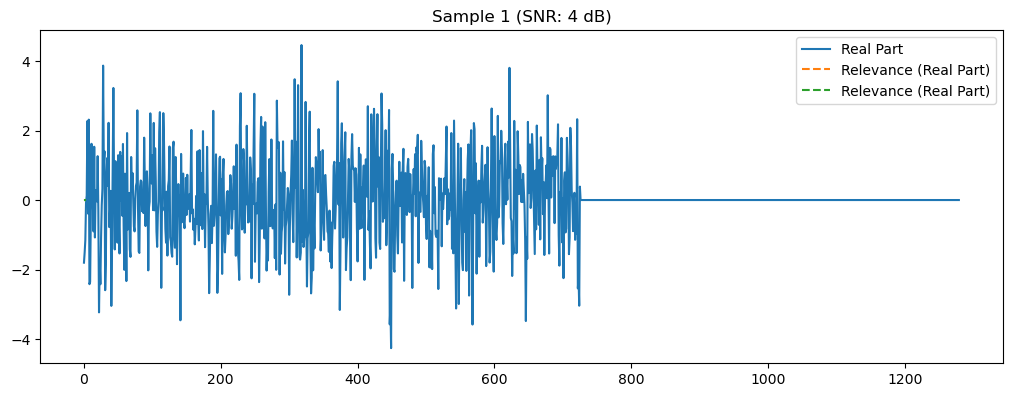

In [22]:
import torch
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from models.LSTM import BiLSTM


class LRP:
    def __init__(self, model, device, epsilon=1e-6):
        self.model = model
        self.epsilon = epsilon
        self.device = device
    
    def relevance(self, x, lengths, target=None):
        x = x.to(self.device)
        lengths = lengths.to(self.device)
        output, h, a = self.model(x, lengths, lstm_outputs=True)
        target = torch.argmax(output, dim=1) if target is None else target
        # Output shape: torch.Size([batch_size, cls_size])
        # Hidden states shape: torch.Size([batch_size, length, hidden_size*2])
        # Attention weights shape: torch.Size([batch_size, length])
        # Context shape: torch.Size([batch_size, hidden_size*2])
        
        r = torch.zeros_like(output)
        for i in range(output.size(0)):
            r[i, target[i]] = output[i, target[i]] # Target class에 대한 relevance만 생존
        
        r_c = self.bpp_fc(h, r)
        r_h = self.bpp_att(r_c, h, a)
        r_x = self.bpp_bilstm(r_h, h, x, lengths)
        
        return r_x
    
    def lstm_gates(self, x_t, h_prev, W_ih, W_hh, b_ih, b_hh, cl_prev):
        x_t = x_t.to(self.device)
        h_prev = h_prev.to(self.device)
        cl_prev = cl_prev.to(self.device)
        
        gates = torch.matmul(W_ih, x_t) + torch.matmul(W_hh, h_prev) + b_ih + b_hh
        i_t, f_t, o_t, g_t = torch.chunk(gates, 4, dim=0)
        
        i_t = torch.sigmoid(i_t)
        f_t = torch.sigmoid(f_t)
        o_t = torch.sigmoid(o_t)
        cl_t = f_t * cl_prev + i_t * torch.tanh(g_t)
        
        return (f_t, i_t, o_t, cl_t)
        
    def bpp_bilstm(self, rel_h, h, x, lengths):
        B, T, H = h.size()
        H = H // 2
        D = x.size(-1)
        
        rel_x_fw = torch.zeros(B, T, D)                     # [B, T, D]
        rel_cl_fw_t1 = torch.zeros(B, H)                    # [B, H]
        W_ih = self.model.lstm.weight_ih_l0                             # [4*h, input_size]
        W_hh = self.model.lstm.weight_hh_l0                             # [4*h, hidden_size]
        b_ih = self.model.lstm.bias_ih_l0
        b_hh = self.model.lstm.bias_hh_l0
        
        rel_x_bw = torch.zeros(B, T, 2)
        rel_cl_bw_t1 = torch.zeros(B, H)
        W_ih_bw = self.model.lstm.weight_ih_l0_reverse
        W_hh_bw = self.model.lstm.weight_hh_l0_reverse
        b_ih_bw = self.model.lstm.bias_ih_l0_reverse
        b_hh_bw = self.model.lstm.bias_hh_l0_reverse
        
        # relevance는 cell state와 gate 값들을 통해 전파됨
        # rel_h_t : [B, T, sigma]
        # rel_x_fw[i, t] : [d] / rel_cl_fw_t1[i] : [h]
        for i in range(B):                                    # B
            h_prev_fw = torch.zeros(H)
            cl_prev_fw = torch.zeros(H)
            for t in reversed(range(T)):                      # T
                if t < lengths[i]:
                    x_t = x[i, t]                             # [H]
                    rel_h_fw_t = rel_h[i, t, :H]              # [H]
                    
                    f_t, i_t, o_t, cl_t = self.lstm_gates(x_t, h_prev_fw, W_ih, W_hh, b_ih, b_hh, cl_prev_fw) # [H]
                    rel_x_fw[i, t], rel_cl_fw_t1[i] = self.bpp_lstm_cell(rel_h_fw_t,        # [H]
                                                                         rel_cl_fw_t1[i],   # [H]
                                                                         f_t, o_t, cl_t,    # [H]
                                                                         W_ih)              # [4*H, D]
                    
                    cl_prev_fw = cl_t
            
            h_prev_bw = torch.zeros(H)
            cl_prev_bw = torch.zeros(H)
            for t in range(T):
                if t < lengths[i]:
                    x_t = x[i, t]
                    rel_h_bw_t = rel_h[i, t, H:]
                    bf_t, bi_t, bo_t, bcl_t = self.lstm_gates(x_t, h_prev_bw, W_ih, W_hh, b_ih, b_hh, cl_prev_bw) # [H]
                    rel_x_bw[i, t], rel_cl_bw_t1[i] = self.bpp_lstm_cell(rel_h_bw_t, 
                                                                         rel_cl_bw_t1[i], 
                                                                         bf_t, bo_t, bcl_t, 
                                                                         W_ih_bw)
                    # h_prev_bw = h_bw_t
                    cl_prev_bw = bcl_t
                    
        rel_x = rel_x_fw + rel_x_bw
        return rel_x
        
    def bpp_lstm_cell(self, rel_h_t, rel_cl_t1, f_t, o_t, cl_t, W_ih):
        rel_cl_t1 = rel_cl_t1.to(self.device)                           # [B, H]
        
        # rel_cl_t = rel_h_t * o_t * (1-torch.tanh(cl_t)**2)            # 현재 타임스텝 간 relevance 흐름만 고려한 경우
        rel_cl_t = rel_cl_t1 + rel_h_t * o_t * (1-torch.tanh(cl_t)**2)  # 전체 타입스텝 간 relevance 흐름을 고려 : [B, H]
        rel_cl_t1 = rel_cl_t * f_t
        
        _, _, W_ih_o, W_ih_cl = torch.chunk(W_ih, 4, dim=0)             # _, _, W_ih_o, W_ih_cl : [H, D]
        rel_x_o = torch.matmul(W_ih_o.T, rel_cl_t * o_t)                # [B, D, H]
        rel_x_cl = torch.matmul(W_ih_cl.T, rel_cl_t * torch.tanh(cl_t)) # [B, D, H]
        rel_x_t = rel_x_o + rel_x_cl # [batch_size, d, sigma]           # [B, D, H]
        
        return rel_x_t, rel_cl_t1
        
    def bpp_att(self, r_c, h, w):
        rel_h = torch.zeros_like(h)
        for i in range(h.size(0)):
            rel_h_t = r_c[i].unsqueeze(0) * w[i].unsqueeze(-1)
            rel_h[i] = rel_h_t

        return rel_h
    
    def bpp_fc(self, c, r):
        fc_W = self.model.fc.weight
        rel_c = torch.zeros_like(c)
        for i in range(r.size(0)):
            for j in range(r.size(1)):
                rel_c[i] += (c[i]*fc_W[j]) * r[i, j] / (fc_W[j].abs().sum() + self.epsilon)
        return rel_c
        
    
def explain_set(config, train_dataset):
    device = config.device
    model = BiLSTM(input_size=2, hidden_size=128, num_layers=2, num_classes=12)

    state_dict = {}
    for k,v in torch.load('./ckpts/result_loss.pt').items():
        nk = k.replace('module.', '')
        state_dict[nk] = v
        
    model.load_state_dict(state_dict)
    model.to(device)
    model.eval()   
    
    lrp = LRP(model, device=device)
    batch = DataLoader(train_dataset, batch_size=4, shuffle=True, collate_fn=model.collate)
    
    fig = plt.figure(figsize=(20, 15))
    with torch.no_grad():
        for batch_idx, (data_batch, labels_batch, snrs_batch, lengths_batch) in enumerate(batch):
            r_scores = lrp.relevance(data_batch, lengths_batch)

            real_part = data_batch[batch_idx][:, 0].cpu().numpy()  # 실수부
            imag_part = data_batch[batch_idx][:, 1].cpu().numpy()  # 허수부
            r_scores_real = r_scores[:, 0].cpu().numpy()   # Relevance 실수부

            ax = fig.add_subplot(4, 2, batch_idx + 1)
            ax.plot(real_part, label='Real Part')
            ax.plot(r_scores_real, label='Relevance (Real Part)', linestyle='--')
            ax.set_title(f'Sample {batch_idx+1} (SNR: {snrs_batch[batch_idx]} dB)')
            ax.legend()

            break  

    plt.tight_layout()
    plt.show()

from models._config import C
c = C()
explain_set(c, dataset)

In [ ]:
import os
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader
from models.LSTM import BiLSTM

def complex_sep(data):
    data = data.replace('i', 'j')  # 'i'를 'j'로 변경하여 복소수 형식에 맞춤
    complex_numbers = data.split(',')  # 쉼표로 구분된 복소수 분리
    complex_list = []
    for num in complex_numbers:
        num = complex(num.strip())
        complex_list.append(num)
    return complex_list

def exaplin_set(data):
    model = BiLSTM(input_size=2, hidden_size=128, num_layers=2, num_classes=12)
    model.load_state_dict(torch.load('/home/kiwan/TSC_XAI/ckpts/ 0dB/LSTM_ 0dB_0.0073.pt'))
    model.eval()
    
    lrp = LRP(model)
    with torch.no_grad():
        x = torch.tensor(data, dtype=torch.float).unsqueeze(0)
        lengths = torch.tensor([len(data)], dtype=torch.long)
        relevance = lrp.get_relevance(x, lengths)
	
	
        
dataset = '/data/kiwan/dataset-CWD-1000/'
signals = ['Barker', 'Costas', 'Frank', 'LFM', 'P1', 'P2', 'P3', 'P4', 'T1', 'T2', 'T3', 'T4']

for signal in signals:
    real_parts = []
    plt.figure(figsize=(20, 5))
    data_dir = os.path.join(dataset, signal)
    data_file = os.listdir(data_dir)
    for ie, file in enumerate(data_file):
        with open(os.path.join(data_dir, file), 'r') as f:
            data = f.readlines()
            data = [complex_sep(d) for d in data]
            data = [item for sublist in data for item in sublist]
            
            

        for c in data:
            real_parts.append(c.real)

        plt.axvline(x=len(real_parts), color='r', linestyle='--')
            
        if ie == 5:
            break


    plt.plot(real_parts, label='Real Part')
    # plt.plot(imag_parts, label='Imaginary Part')
    plt.title(f'{signal} Signal: Real and Imaginary Parts over Time')
    plt.xlabel('Sample Index')
    plt.ylabel('Value')
    plt.legend()
    plt.grid(True)
    plt.show()
        

In [ ]:

def explain_set(train_dataset):
    model = BiLSTM(input_size=2, hidden_size=128, num_layers=2, num_classes=12)
    model.load_state_dict(torch.load('/home/kiwan/TSC_XAI/ckpts/ 0dB/LSTM_ 0dB_0.0073.pt'))
    model.eval()
    
    lrp = LRP(model)

    batch = DataLoader(train_dataset, batch_size=2, shuffle=True, collate_fn=model.collate)

    fig = plt.figure(figsize=(20, 15))

    with torch.no_grad():
        for data_batch, labels, snr, lengths in batch:
            for i in range(len(data_batch)):
                data = data_batch[i]
                seq_len = lengths[i].item()  
                print(seq_len)
                
                # LRP로 Relevance 스코어 계산
                r_scores = lrp.get_relevance(data, seq_len)

                real_part = data_batch[i][:, 0].cpu().numpy()  # 실수부
                r_scores_real = r_scores[:, 0].cpu().numpy()   # Relevance 실수부

                ax = fig.add_subplot(4, 2, i + 1)
                ax.plot(real_part, label='Real Part')
                ax.plot(r_scores_real, label='Relevance (Real Part)', linestyle='--')
                ax.set_title(f'Sample {i+1} (SNR: {snr[i]} dB)')
                ax.legend()

            break

    plt.tight_layout()
    plt.show()

explain_set(train_dataset)